In [1]:
import cv2
import numpy as np
from PIL import Image  
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

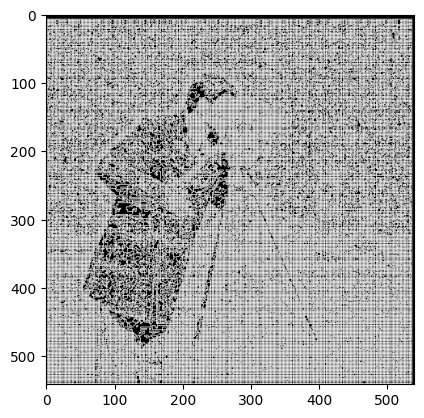

In [30]:
# part 1.1
D_x = np.array([[1, -1]])
D_y = np.array([[1], [-1]])

image_path = 'cameraman.png'  
image = Image.open(image_path).convert('L') 
image = np.array(image) / 255.0  

Ix = convolve2d(image, D_x, mode='same', boundary='symm')
Iy = convolve2d(image, D_y, mode='same', boundary='symm')

gradient_magnitude = np.sqrt(Ix**2 + Iy**2)

threshold = 0.2
edge_image = gradient_magnitude > threshold

plt.imsave('edge_image_diff.png', edge_image, cmap='gray')
plt.imshow(edge_image, cmap='gray')

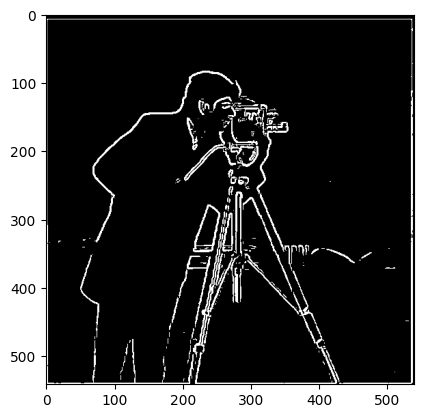

In [3]:
# part 1.2
sigma = 1.0  
size = int(6 * sigma + 1)  
gaussian_1d = cv2.getGaussianKernel(size, sigma)
gaussian_2d = np.outer(gaussian_1d, gaussian_1d.T)  

DoG_x = convolve2d(gaussian_2d, D_x, mode='same', boundary='symm')
DoG_y = convolve2d(gaussian_2d, D_y, mode='same', boundary='symm')

Ix_DoG = convolve2d(image, DoG_x, mode='same', boundary='symm')
Iy_DoG = convolve2d(image, DoG_y, mode='same', boundary='symm')

gradient_magnitude_DoG = np.sqrt(Ix_DoG**2 + Iy_DoG**2)

threshold_DoG = 0.1  
edge_image_DoG = gradient_magnitude_DoG > threshold_DoG

plt.imsave('edge_image_DoG.png', edge_image, cmap='gray')
plt.imshow(edge_image_DoG, cmap='gray')

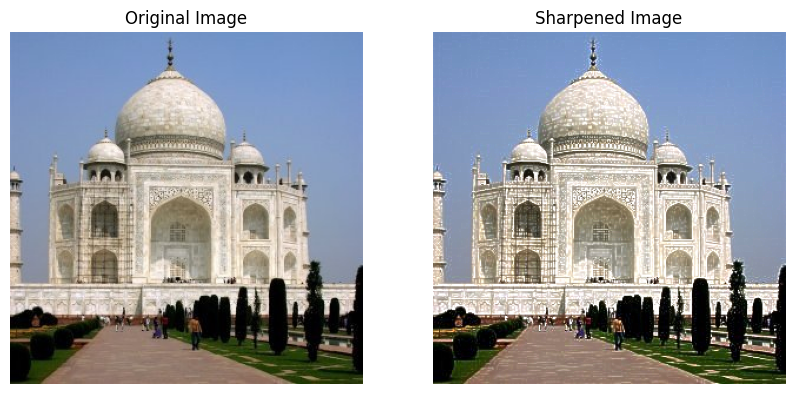

In [4]:
# part 2.1
def unsharp_mask(image_path):
    original = cv2.imread(image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) 

    blurred = cv2.GaussianBlur(original, (0, 0), 1)

    high_frequencies = cv2.subtract(original, blurred)

    sharpened = cv2.addWeighted(original, 1, high_frequencies, 3, 0)

    return original, sharpened

image_path = 'taj.jpg'  
original, sharpened = unsharp_mask(image_path)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sharpened Image')
plt.imshow(sharpened)
plt.axis('off')
plt.show()

In [5]:
# part 2.2
from scipy.ndimage import gaussian_filter

def hybrid_image(im1, im2, sigma1, sigma2):
    low_frequencies = gaussian_filter(im2, sigma=sigma2)
    high_frequencies = im1 - gaussian_filter(im1, sigma=sigma1)
    hybrid = low_frequencies + high_frequencies
    return np.clip(hybrid, 0, 1)  


def pyramids(image, N):
    gaussian_pyramid = [image]
    laplacian_pyramid = []
    for i in range(N):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    for i in range(N):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i + 1])
        laplacian = cv2.subtract(gaussian_pyramid[i], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    plt.figure(figsize=(15, 10))
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(gaussian_pyramid[i])
        plt.axis('off')
        plt.title(f'Gaussian Level {i}')
        plt.subplot(2, N, i + N + 1)
        plt.imshow(laplacian_pyramid[i])
        plt.axis('off')
        plt.title(f'Laplacian Level {i}')
    plt.tight_layout()
    plt.show()


In [6]:
def hybrid_image(im1, im2, sigma1, sigma2):
    high_frequencies = im1 - gaussian_filter(im1, sigma=sigma2)
    low_frequencies = gaussian_filter(im2, sigma=sigma1)
    hybrid = np.clip(low_frequencies + high_frequencies, 0, 1)    
    return hybrid

def pyramids(image, N):
    gaussian_pyramid = [image]
    laplacian_pyramid = []
    for i in range(N - 1):
        blurred = gaussian_filter(gaussian_pyramid[-1], sigma=2)
        gaussian_pyramid.append(blurred)
    for i in range(N - 1):
        laplacian = gaussian_pyramid[i] - gaussian_pyramid[i + 1]
        laplacian_pyramid.append(laplacian)
    laplacian_pyramid.append(gaussian_pyramid[-1])
    plt.figure(figsize=(12, 8))
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(gaussian_pyramid[i], cmap='gray')
        plt.title(f'Gaussian level {i + 1}')
        plt.axis('off')
    for i in range(N):
        plt.subplot(2, N, i + N + 1)
        plt.imshow(laplacian_pyramid[i], cmap='gray')
        plt.title(f'Laplacian level {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

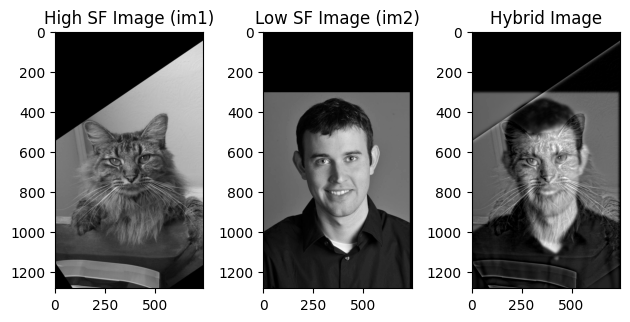

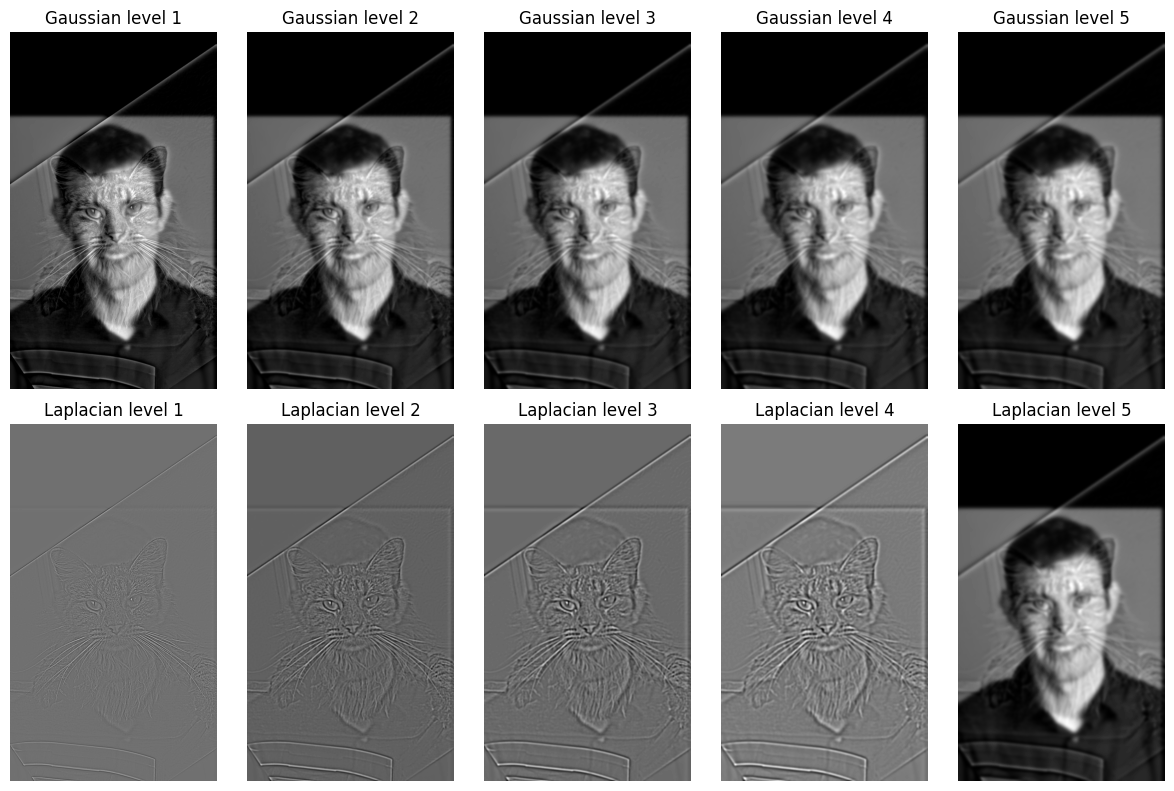

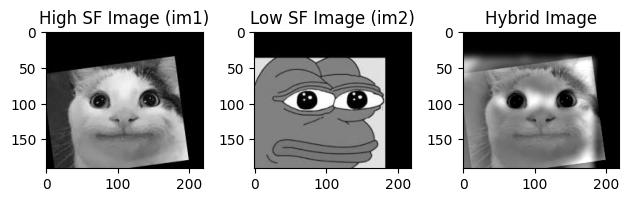

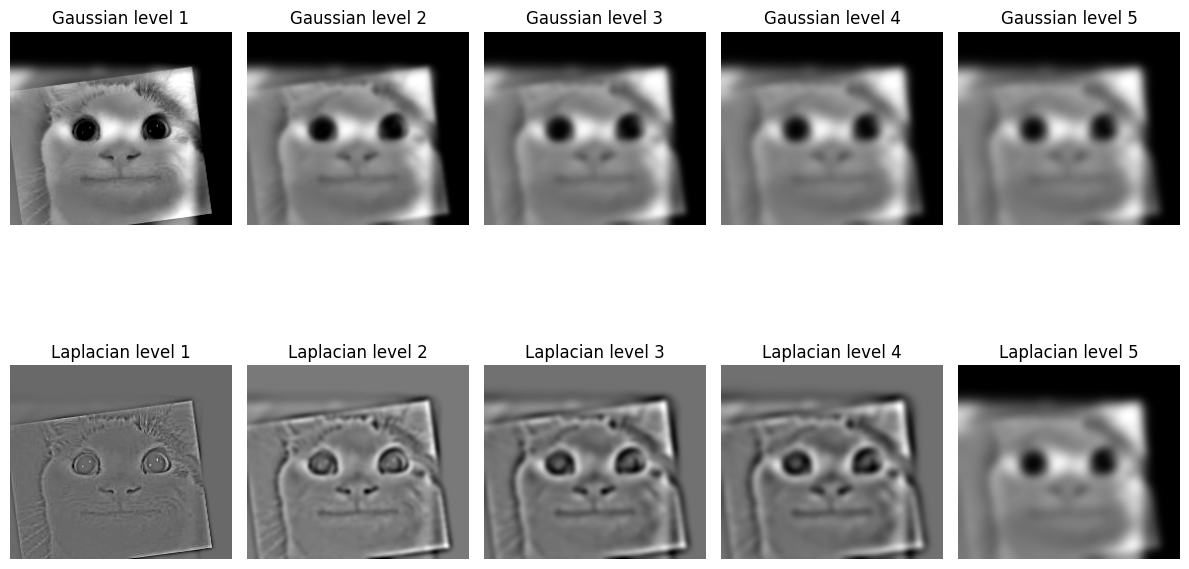

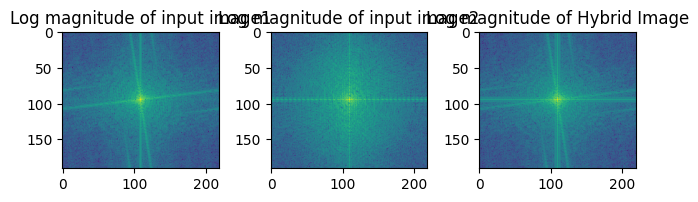

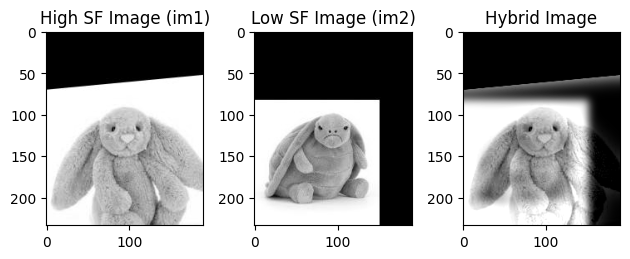

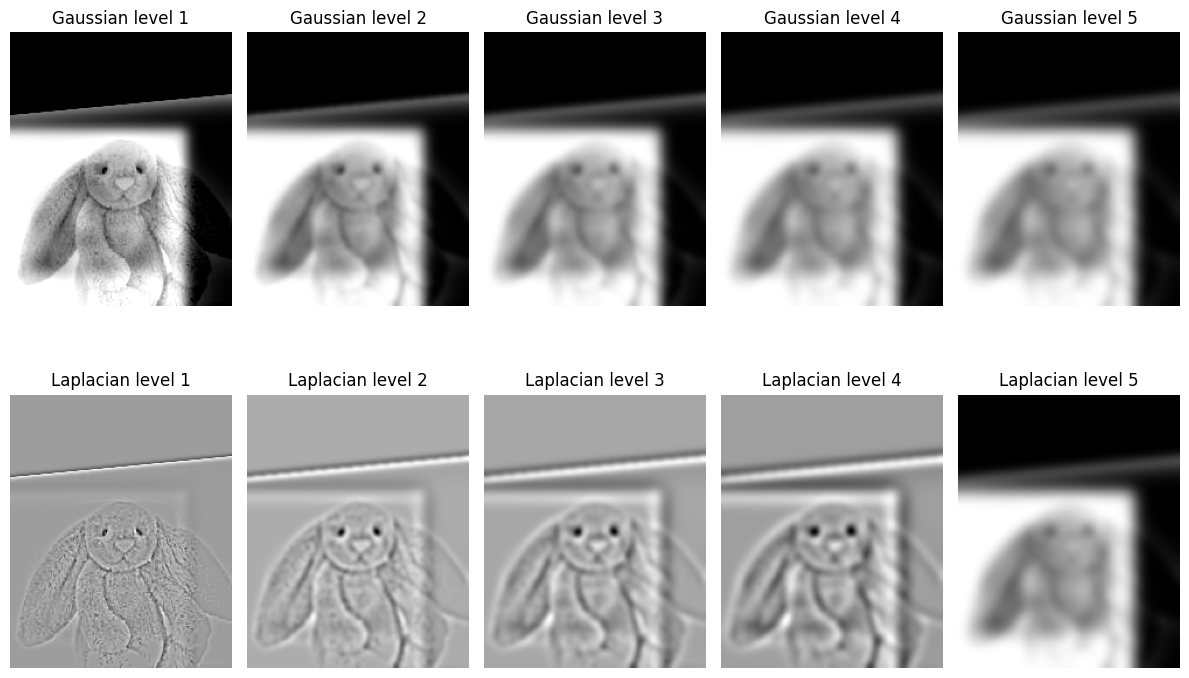

In [32]:
# First load images
# (high sf, low sf)
image_pairs = [
    ('./aligned/nutmeg.jpg', './aligned/DerekPicture.jpg'),
    ('./aligned/cat.jpg', './aligned/frog.jpg'),
    ('./aligned/jellybunny.jpg', './aligned/jellyturtle.jpg')
]

sigma1 = 5
sigma2 = 10

for high_sf_path, low_sf_path in image_pairs:
    im1 = np.array(Image.open(high_sf_path).convert('L')) / 255.0
    im2 = np.array(Image.open(low_sf_path).convert('L')) / 255.0

    ## You will provide the code below. Sigma1 and sigma2 are arbitrary 
    ## cutoff values for the high and low frequencies
    hybrid = hybrid_image(im1, im2, sigma1, sigma2)

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(im1, cmap='gray')
    plt.title('High SF Image (im1)')
    plt.subplot(1, 3, 2)
    plt.imshow(im2, cmap='gray')
    plt.title('Low SF Image (im2)')
    plt.subplot(1, 3, 3)
    plt.imshow(hybrid, cmap='gray')
    plt.title('Hybrid Image')
    plt.tight_layout()
    plt.show()

    ## Compute and display Gaussian and Laplacian Pyramids
    ## You also need to supply this function
    N = 5 # suggested number of pyramid levels (your choice)
    pyramids(hybrid, N)

    if high_sf_path == './aligned/cat.jpg':
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im1)))))
        plt.title('Log magnitude of input image1')
        plt.subplot(1, 3, 2)
        plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(im2)))))
        plt.title('Log magnitude of input image2')
        plt.subplot(1, 3, 3)
        plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(hybrid)))))
        plt.title('Log magnitude of Hybrid Image')
        plt.tight_layout()
        plt.show()

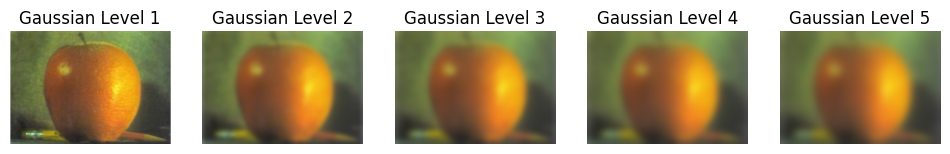

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


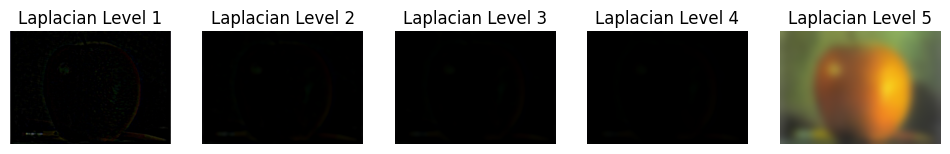

In [33]:
# part 2.3
def gaussian_stack(image, num_levels, sigma=50):
    stack = [image]
    for i in range(1, num_levels):
        blurred_image = np.zeros_like(image)
        for channel in range(image.shape[2]):  
            blurred_image[:, :, channel] = gaussian_filter(stack[-1][:, :, channel], sigma=sigma)
        stack.append(blurred_image)
    return stack

def laplacian_stack(gaussian_stack):
    laplacian_stack = []
    for i in range(len(gaussian_stack) - 1):
        laplacian = gaussian_stack[i] - gaussian_stack[i + 1]
        laplacian_stack.append(laplacian)
    
    laplacian_stack.append(gaussian_stack[-1])
    
    return laplacian_stack

def display_stack(stack, stack_type):
    num_levels = len(stack)
    plt.figure(figsize=(12, 6))
    for i in range(num_levels):
        plt.subplot(1, num_levels, i+1)
        plt.imshow(stack[i])
        plt.title(f'{stack_type} Level {i+1}')
        plt.axis('off')
    plt.show()

image_path = './oraple/oraple.jpg'  
image = np.array(Image.open(image_path)) / 255.0

num_levels = 5  
sigma = 5    
gaussian_stack_images = gaussian_stack(image, num_levels, sigma)
laplacian_stack_images = laplacian_stack(gaussian_stack_images)

display_stack(gaussian_stack_images, stack_type='Gaussian')

display_stack(laplacian_stack_images, stack_type='Laplacian')


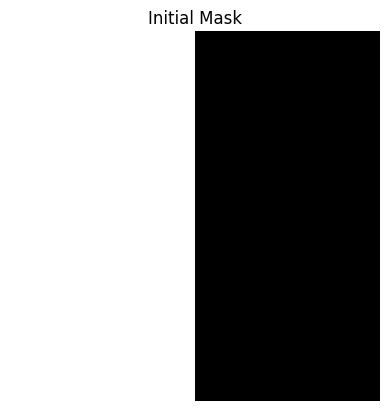

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


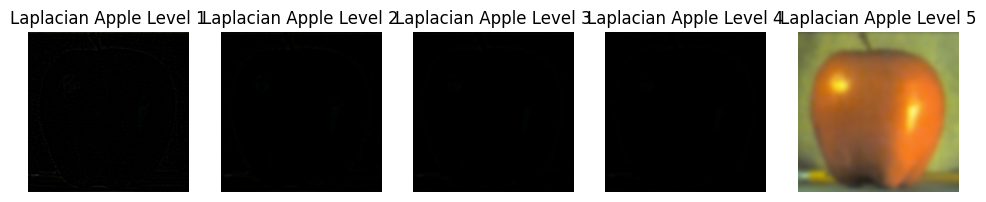

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


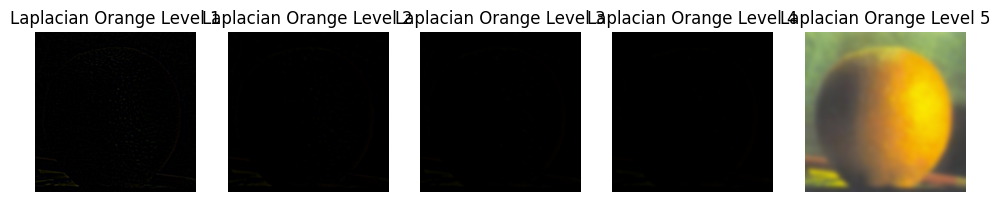

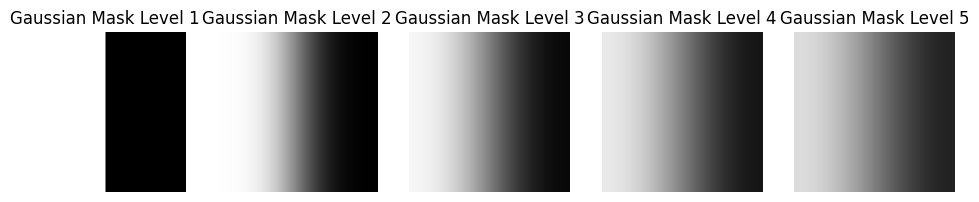

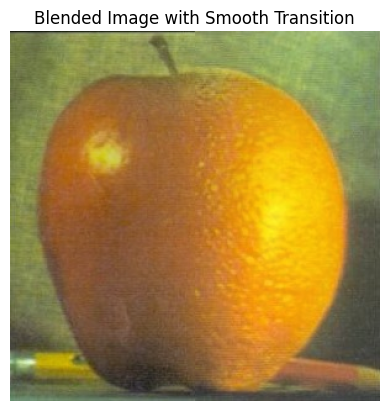

In [35]:
# part 2.4
def blend_images(laplacian_stack1, laplacian_stack2, mask_stack):
    blended_stack = []
    for i in range(len(laplacian_stack1)):
        blended = laplacian_stack1[i] * mask_stack[i] + laplacian_stack2[i] * (1 - mask_stack[i])
        blended_stack.append(blended)
    return blended_stack

def reconstruct_from_laplacian(laplacian_stack):
    reconstructed_image = laplacian_stack[-1]
    for i in reversed(range(len(laplacian_stack) - 1)):
        reconstructed_image = laplacian_stack[i] + reconstructed_image
    return reconstructed_image

image1_path = 'oraple/apple.jpeg'
image2_path = 'oraple/orange.jpeg'
image1 = np.array(Image.open(image1_path)) / 255.0
image2 = np.array(Image.open(image2_path)) / 255.0

mask = np.zeros((image1.shape[0], image1.shape[1]), dtype=np.float32)
mask[:, :image1.shape[1] // 2] = 1  

plt.figure()
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')
plt.show()

num_levels = 5
sigma = 50  
mask_stack = gaussian_stack(np.stack([mask]*3, axis=-1), num_levels, sigma=sigma)

gaussian_stack1 = gaussian_stack(image1, num_levels, sigma=2)
gaussian_stack2 = gaussian_stack(image2, num_levels, sigma=2)

laplacian_stack1 = laplacian_stack(gaussian_stack1)
laplacian_stack2 = laplacian_stack(gaussian_stack2)

blended_stack = blend_images(laplacian_stack1, laplacian_stack2, mask_stack)

blended_image = reconstruct_from_laplacian(blended_stack)

display_stack(laplacian_stack1, 'Laplacian Apple')
display_stack(laplacian_stack2, 'Laplacian Orange')
display_stack(mask_stack, 'Gaussian Mask')

plt.figure()
plt.imshow(np.clip(blended_image, 0, 1))
plt.title('Blended Image with Smooth Transition')
plt.axis('off')
plt.show()

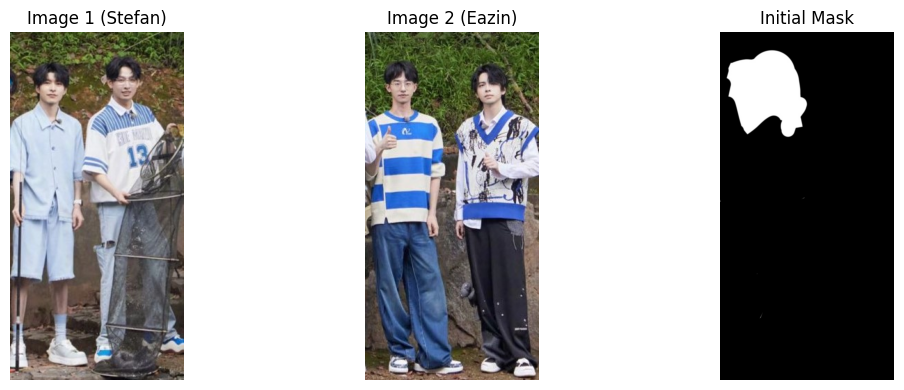

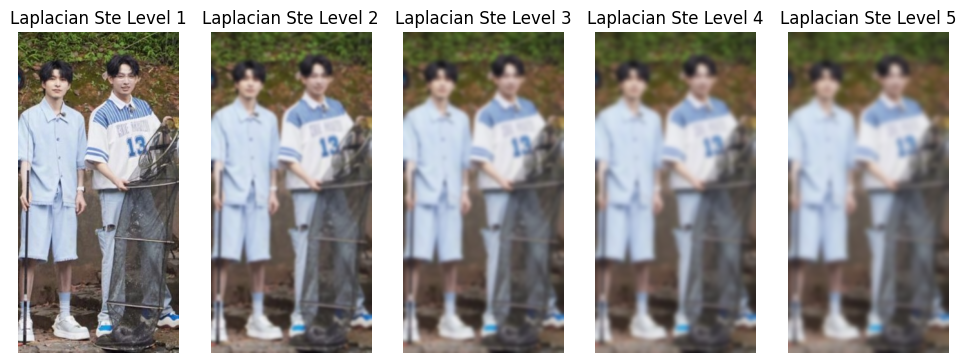

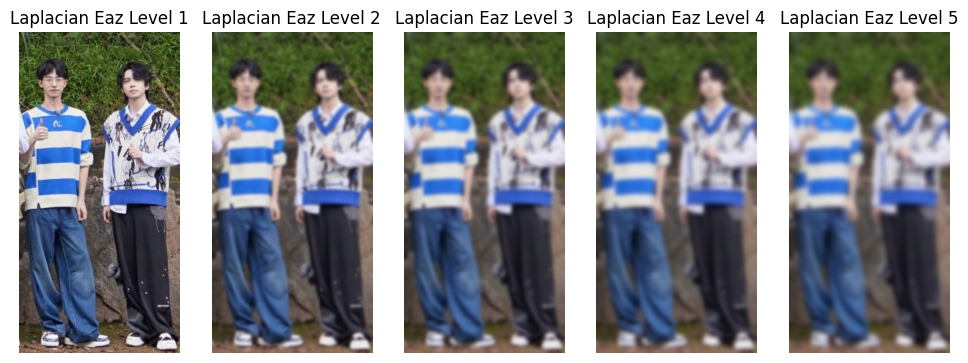

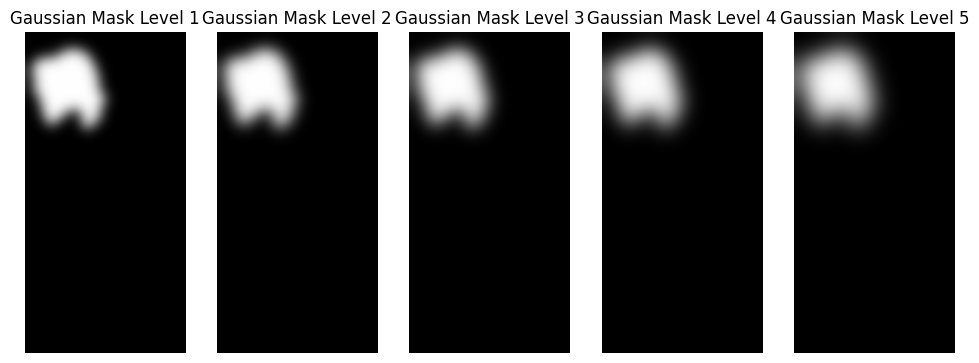

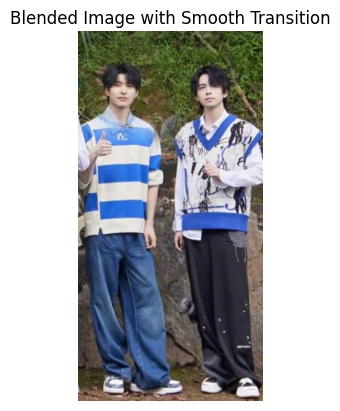

In [60]:
# part 2.4
def blend_images(laplacian_stack1, laplacian_stack2, mask_stack):
    blended_stack = []
    for i in range(len(laplacian_stack1)):
        blended = laplacian_stack1[i] * mask_stack[i] + laplacian_stack2[i] * (1 - mask_stack[i])
        blended_stack.append(blended)
    return blended_stack

def reconstruct_from_laplacian(laplacian_stack):
    reconstructed_image = laplacian_stack[-1]
    for i in reversed(range(len(laplacian_stack) - 1)):
        reconstructed_image = laplacian_stack[i] + reconstructed_image
    return reconstructed_image

image1_path = 'oraple/stefan.jpg'
image2_path = 'oraple/eazin.jpg'
mask_path = 'oraple/mask.jpg'
image1 = np.array(Image.open(image1_path)) / 255.0
image2 = np.array(Image.open(image2_path)) / 255.0
mask = (np.array(Image.open(mask_path)) / 255.0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image 1 (Stefan)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Image 2 (Eazin)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

num_levels = 5
sigma = 10
mask_stack = []
for i in range(num_levels):
    # Resize the mask to match the image dimensions
    resized_mask = np.array(Image.fromarray((mask * 255).astype(np.uint8)).resize((image1.shape[1], image1.shape[0]))) / 255.0
    
    # Ensure 3 channels (for RGB)
    if len(resized_mask.shape) == 2:  # Grayscale mask
        resized_mask = np.stack([resized_mask] * 3, axis=-1)

    # Apply increasing Gaussian blur for different levels
    blurred_mask = gaussian_filter(resized_mask, sigma=sigma + i * 2)  # Increase blur with each level

    mask_stack.append(blurred_mask)

gaussian_stack1 = gaussian_stack(image1, num_levels, sigma=2)
gaussian_stack2 = gaussian_stack(image2, num_levels, sigma=2)

laplacian_stack1 = laplacian_stack(gaussian_stack1)
laplacian_stack2 = laplacian_stack(gaussian_stack2)

blended_stack = blend_images(laplacian_stack1, laplacian_stack2, mask_stack)

blended_image = reconstruct_from_laplacian(blended_stack)

display_stack(gaussian_stack1, 'Laplacian Ste')
display_stack(gaussian_stack2, 'Laplacian Eaz')
display_stack(mask_stack, 'Gaussian Mask')

plt.figure()
plt.imshow(np.clip(blended_image, 0, 1))
plt.title('Blended Image with Smooth Transition')
plt.axis('off')
plt.show()